In [232]:
from math import log
from random import choices
import numpy as np
from functools import reduce
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from random import choice
import pandas as pd
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

In [103]:
from folktables import ACSDataSource, ACSEmployment, ACSPublicCoverage
data_source = ACSDataSource(survey_year=2018, horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=['NY'], download=True)
X, y, group = ACSPublicCoverage.df_to_numpy(acs_data)

columns = [
            'AGEP',
            'SCHL',
            'MAR',
            'SEX',
            'DIS',
            'ESP',
            'CIT',
            'MIG',
            'MIL',
            'ANC',
            'NATIVITY',
            'DEAR',
            'DEYE',
            'DREM',
            'PINCP',
            'ESR',
            'ST',
            'FER',
            'RAC1P',
        ]
X = pd.DataFrame(X, columns=columns)
X_ = X.to_numpy()

In [168]:
from sklearn import preprocessing

bike = pd.read_csv("hour.csv")
X_2 = bike.drop(["cnt", "dteday", "instant", "registered"], axis=1)
y_2 = bike["cnt"]
y_2 = (y_2-y_2.min())/(y_2.max() - y_2.min())
X_2.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0


In [478]:
from sklearn.metrics import accuracy_score, mean_squared_error


def partition_base(model, data, num_buckets):
    preds = model.predict(data)
    output = []
    for i in range(num_buckets):
        cond = (preds > (i / num_buckets)) & (preds < ((i + 1) / num_buckets))
        output.append(cond)
    return output

class MC:
    def __init__(self, init_model, num_buckets=2, max_iter=10, partition=partition_base):
        self.alpha = 1e-4
        self.eta = 1
        self.buckets = num_buckets
        self.max_iter = max_iter
        self.models = [init_model]
        self.partition = partition
        

    def update_probs(self, orig_probs, model, mask, data):
        diffs = np.zeros(len(orig_probs))
        diffs[mask] = model.predict(data)[mask]
        new_probs = np.exp(-self.eta * diffs)
        return new_probs * orig_probs

    def multicalibrate(self, oracle, data, labels):
        
        init_model = self.models[0]
        initial_preds = init_model.predict(data)
        resids = initial_preds - labels
        new_probs = initial_preds

        partitions = self.partition(model, data, self.buckets) #+ [np.full(len(initial_preds), True)]
        self.parts = []

        for _ in range(self.max_iter):
            errs = []
            grp_models = []
            for b in range(self.buckets):
                d_t = data.loc[partitions[b]]
                residuals = resids[partitions[b]]
                if len(d_t):
                    h_ = oracle(d_t, residuals)
                    yhat = h_.predict(d_t)
                    errs.append(mean_squared_error(residuals, yhat))
                    grp_models.append(h_)    

                
            if np.max(errs) < self.alpha:
                break
                
            idx = np.argmax(errs)
            worst_model = grp_models[idx]
            self.parts.append(partitions[idx])
            new_probs = self.update_probs(
                new_probs,
                worst_model,
                partitions[idx],
                data,
            )
            resids = new_probs - labels
            self.models.append(worst_model)
    
    def predict_probs(self, X):
        n = len(self.models)
        new_preds = self.models[0].predict(X)
        for i in range(1, n):
            mask = self.parts[i-1]
            new_preds = self.update_probs(new_preds, self.models[i], mask, X)
        return new_preds

In [213]:
def LinReg(X, y):
    reg = LinearRegression()
    reg.fit(X, y)
    return reg

def GBT_C(X, y):
    reg = GradientBoostingClassifier(max_depth=3)
    reg.fit(X, y)
    return reg

def GBT_R(X, y):
    reg = GradientBoostingRegressor(max_depth=2)
    reg.fit(X, y)
    return reg

def LogReg(X, y):
    reg = LogisticRegression()
    reg.fit(X, y)
    reg.predict = lambda x : reg.predict_proba(x)[..., 0]
    return reg

In [328]:
model = LinReg(X, y)

In [95]:
mc = MC(model, 2, 5)

In [96]:
mc.multicalibrate(LinReg, X, y)

In [97]:
yhat = mc.predict_probs(X)

In [98]:
mean_squared_error(y, yhat)

0.2070284553714592

In [251]:
print(mean_squared_error(y, model.predict(X)))

print(mean_squared_error(y, GBT_R(X, y).predict(X)))

0.36384177779049204
0.1848562710117659


In [242]:
errs = []
for i in range(1, 10+1):
    mc = MC(model, 2, i)
    mc.multicalibrate(LinReg, X, y)
    yhat = mc.predict_probs(X)
    errs.append(mean_squared_error(y, yhat))

Text(0.5, 0, 'Number of iterations')

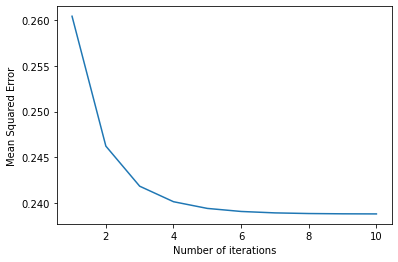

In [248]:
plt.plot(range(1, 10+1), errs)
plt.ylabel("Mean Squared Error")
plt.xlabel("Number of iterations")

In [261]:
errs = []
for i in range(1, 5+1):
    mc = MC(GBT_R(X_, y), i+1, 5)
    mc.multicalibrate(GBT_R, X, y)
    yhat = mc.predict_probs(X)
    errs.append(mean_squared_error(y, yhat))

Text(0.5, 0, 'Number of buckets')

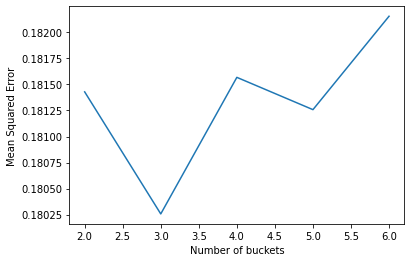

In [262]:
plt.plot(range(2, 6+1), errs)
plt.ylabel("Mean Squared Error")
plt.xlabel("Number of buckets")

In [214]:
m2 = LinReg(X_2, y_2)

In [217]:
mean_squared_error(y_2, m2.predict(X_2))

0.013463629892315913

In [240]:
errs = []
for i in range(1, 5+1):
    mc2 = MC(m2, 10, i)
    mc2.multicalibrate(GBT_R, X_2, y_2)
    yhat2 = mc2.predict_probs(X_2)
    errs.append(mean_squared_error(y_2, yhat2))

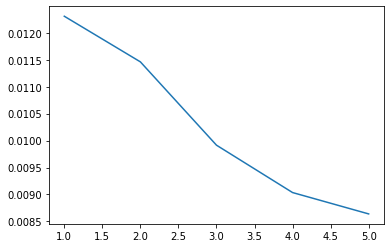

In [241]:
plt.plot(range(1, 5+1), errs)

In [284]:
errs = []
for i in range(1, 20+1):
    mc2 = MC(m2, i, 10)
    mc2.multicalibrate(LinReg, X_2, y_2)
    yhat2 = mc2.predict_probs(X_2)
    errs.append(mean_squared_error(y_2, yhat2))

Text(0, 0.5, 'Mean Squared Error')

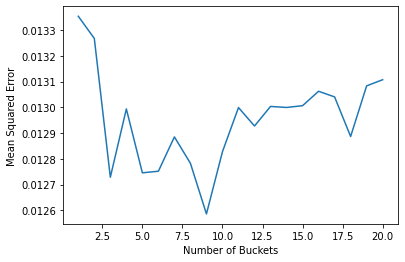

In [300]:
plt.plot(range(1, 20+1), errs)
plt.xlabel("Number of Buckets")
plt.ylabel("Mean Squared Error")

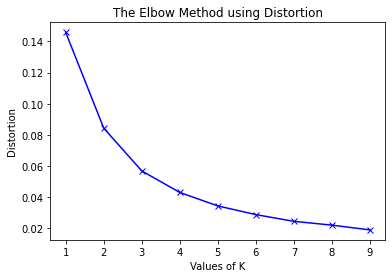

In [314]:
from sklearn import cluster
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    kmeans = cluster.KMeans(n_clusters=k).fit(y_2.values.reshape(-1, 1))
  
    distortions.append(sum(np.min(cdist(y_2.values.reshape(-1, 1), kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / y_2.shape[0])
    inertias.append(kmeans.inertia_)
  
    mapping1[k] = sum(np.min(cdist(y_2.values.reshape(-1, 1), kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / y_2.shape[0]
    mapping2[k] = kmeans.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [306]:
errs = []
m3 = GBT_R(X_2, y_2)
for i in range(1, 20+1):
    print(i)
    mc3 = MC(m3, 4, i)
    mc3.multicalibrate(GBT_R, X_2, y_2)
    yhat3 = mc3.predict_probs(X_2)
    errs.append(mean_squared_error(y_2, yhat3))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0, 0.5, 'Mean Squared Error')

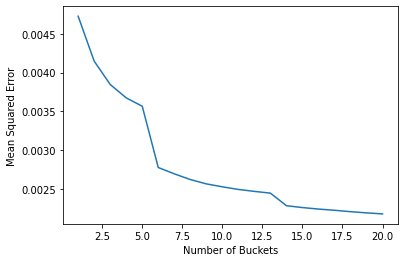

In [308]:
plt.plot(range(1, 20+1), errs)
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Squared Error")

In [429]:
def partition_sex(model, data, num_buckets):
    output = []
    for i in [1.0, 2.0]:
        output.append(data.SEX == i)
    return output

def partition_race(model, data, num_buckets):
    output = []
    for i in [1.0, 2.0, 6.0, 8.0]:
        output.append(data.RAC1P == i)
    return output

def partition_base(model, data, num_buckets):
    preds = model.predict(data)
    output = []
    for i in range(num_buckets):
        cond = (preds > (i / num_buckets)) & (preds < ((i + 1) / num_buckets))
        output.append(cond)
    return output

def partition_base(model, data, num_buckets):
    preds = model.predict(data)
    output = []
    for i in range(num_buckets):
        cond = (preds > (i / num_buckets)) & (preds < ((i + 1) / num_buckets))
        output.append(cond)
    return output


def partition_both(model, data, num_buckets):
    preds = model.predict(data)
    output = []
    for i in range(num_buckets):
        for j in [1.0, 2.0, 6.0, 8.0]:
            cond = (preds > (i / num_buckets)) & (preds < ((i + 1) / num_buckets))
            output.append((cond) & (data.RAC1P == j))
    return output

In [374]:
model = GBT_R(X, y)

mc = MC(model, num_buckets=2, max_iter=20, partition=partition_sex)
mc.multicalibrate(GBT_R, X, y)
yhat = mc.predict_probs(X)

In [417]:
model = GBT_R(X, y)

mc = MC(model, num_buckets=4, max_iter=20, partition=partition_race)
mc.multicalibrate(GBT_R, X, y)
yhat = mc.predict_probs(X)

In [439]:
model = GBT_R(X, y)

mc = MC(model, num_buckets=40, max_iter=10, partition=partition_both)
mc.multicalibrate(GBT_R, X, y)
yhat = mc.predict_probs(X)

In [440]:
mean_squared_error(y, yhat)

0.1849395317401357

In [441]:
mean_squared_error(y, model.predict(X))

0.18485627101176588

In [442]:
errs = []
for r in [1.0, 2.0, 6.0, 8.0]:
    X_ = X[X.RAC1P == r]
    y_ = y[X.RAC1P == r]
    errs.append(mean_squared_error(y_, model.predict(X_)))

In [443]:
errs2=[]
for r in [1.0, 2.0, 6.0, 8.0]:
    X_ = X[X.RAC1P == r]
    y_ = y[X.RAC1P == r]
    errs2.append(mean_squared_error(y_, mc.predict_probs(X)[X.RAC1P == r]))

<BarContainer object of 4 artists>

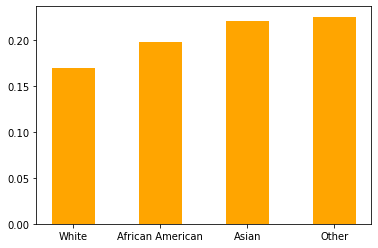

In [444]:
plt.bar(["White", "African American", "Asian", "Other"], errs, width=0.5, color="red")
plt.bar(["White", "African American", "Asian", "Other"], errs2, width=0.5, color="orange")

In [464]:
def partition_season(model, data, num_buckets):
    output = []
    for i in [1.0, 2.0, 3.0, 4.0]:
        output.append(data.season == i)
    return output


model = GBT_R(X_2, y_2)

mc = MC(model, num_buckets=4, max_iter=20, partition=partition_season)
mc.multicalibrate(GBT_R, X_2, y_2)
yhat = mc.predict_probs(X_2)

In [465]:
mean_squared_error(y_2, yhat)
mean_squared_error(y_2, model.predict(X_2))

0.00577861011386891

In [466]:
errs = []
for r in [1.0, 2.0, 3.0, 4.0]:
    X_ = X_2[X_2.season == r]
    y_ = y_2[X_2.season == r]
    errs.append(mean_squared_error(y_, model.predict(X_)))

In [467]:
errs2 = []
for r in [1.0, 2.0, 3.0, 4.0]:
    X_ = X_2[X_2.season == r]
    y_ = y_2[X_2.season == r]
    errs2.append(mean_squared_error(y_, mc.predict_probs(X_2)[X_2.season == r]))

<BarContainer object of 4 artists>

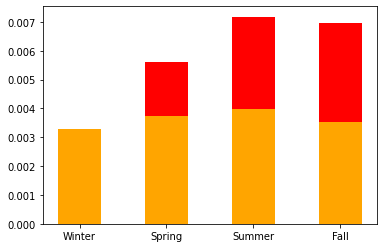

In [468]:
plt.bar(["Winter", "Spring", "Summer", "Fall"], errs, width=0.5, color="red")
plt.bar(["Winter", "Spring", "Summer", "Fall"], errs2, width=0.5, color="orange")

In [484]:
def partition_kmeans(model, data, num_buckets):
    kmeans = cluster.KMeans(n_clusters=3).fit(model.predict(data).reshape(-1, 1))
    l = [0] + sorted(kmeans.cluster_centers_) + [1]
    n = len(l)
    output = []
    for i in range(n-1):
        cond = (preds > l[i]) & (preds < l[i+1])
        output.append(cond)
    return output

errs = []
m3 = GBT_R(X_2, y_2)
for i in range(1, 20+1):
    print(i)
    mc3 = MC(m3, num_buckets=4, max_iter=i, partition=partition_kmeans)
    mc3.multicalibrate(GBT_R, X_2, y_2)
    yhat3 = mc3.predict_probs(X_2)
    errs.append(mean_squared_error(y_2, yhat3))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0, 0.5, 'Mean Squared Error')

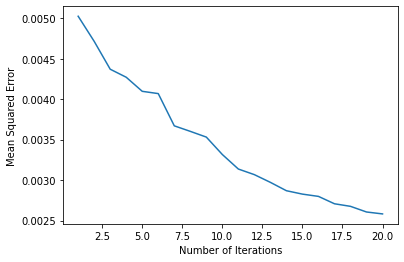

In [485]:
plt.plot(range(1, 20+1), errs)
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Squared Error")

Text(0, 0.5, 'Mean Squared Error')

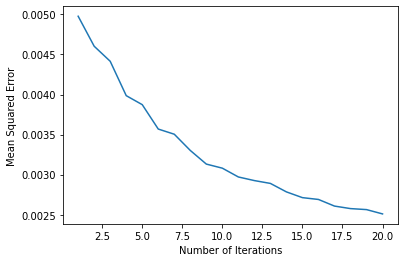

In [475]:
plt.plot(range(1, 20+1), errs)
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Squared Error")

In [479]:
errs = []
m3 = GBT_R(X_2, y_2)
for i in range(1, 20+1):
    print(i)
    mc3 = MC(m3, num_buckets=4, max_iter=i)
    mc3.multicalibrate(GBT_R, X_2, y_2)
    yhat3 = mc3.predict_probs(X_2)
    errs.append(mean_squared_error(y_2, yhat3))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0, 0.5, 'Mean Squared Error')

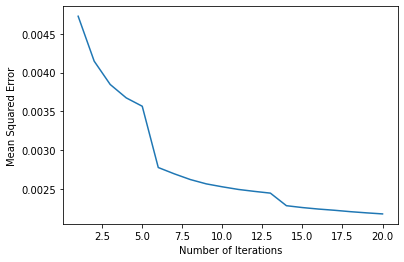

In [480]:
plt.plot(range(1, 20+1), errs)
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Squared Error")